# `prescribe_vec` example: global_with_exf

In this demo of `prescribe_vec`, we will run a simple global model with external forcing conditions for 1 month. Next, we will use output from the global model to replicate a subdomain of the simulation. `prescribe_vec` will be used to prescribe boundary conditions in 2 layers - the size of the computational stencil.

# Contents
1. Section 1: Setup\
    1.1 Clone required repositories\
    1.2 Add packages to MITgcm
2. Section 2: The Global Model\
    2.1 Setup the global model\
    2.2 Build the global model
    2.3 Run the global model\
3. Section 3: The Regional Model\
    3.1 Setup the regional model\
    3.2 Build the regional model\
    3.3 Run the regional model
4. Section 4: Solution comparison\
    4.1 Create comparison functions


# Section 1: Setup

## 1.1 Clone required repositories
To run this experiment, begin by cloning a fresh MITgcm copy and the `prescribe_vec` directory. In addition, this example uses the `diagnostics_vec` package, so also clone this directory.

## 1.2 Add packages to MITgcm
To add the `prescribe_vec` and `diagnostics_vec` packages to the fresh MITgcm clone, use the Python utilities provided with each package:

# Section 2: The Global Model

## 2.1: Setup the global model
In the first part of this example, we run the tutorial forward for 30 days. This simulation is nearly identical to the verification experiment provided with MITgcm except that it uses the `diagnostics_vec` package to output the boundary conditions to be used for the subdomain. Accordingly, the code and input directories only have 6 files which differ from the verification experiement:
1. code/packages.conf - diagnostics_vec is added
2. code/SIZE.h (this experiment runs with mpi)
3. input/data (modified to run for 1 month with deltaT = 1200 s)
4. input/data.pkg - useDiagnostics_vec is set to .TRUE.
5. input/data.exf
6. prepare_run

In addition, there are 3 new files associated with the diagnostics_vec package:
1. code/DIAGNOSTICS_VEC_SIZE.h
2. input/data.diagnostics_vec
3. create_dv_masks.py

To create the setup, first run the `prepare_run` script to collect all of the code and input files from the core tutorial. Note that this scripts expects the `prescribe_vec` and `MITgcm` clones (from above) to be in the same directory.

Next, create the masks for the diagnostics vec package (this will output boundary conditions for the regional model).

### 2.1.1. Plot the diagnostices_vec masks
To observe the locations where the diagnostics_vec package will output data on each mask, we can plot the masks on the global bathymetry:


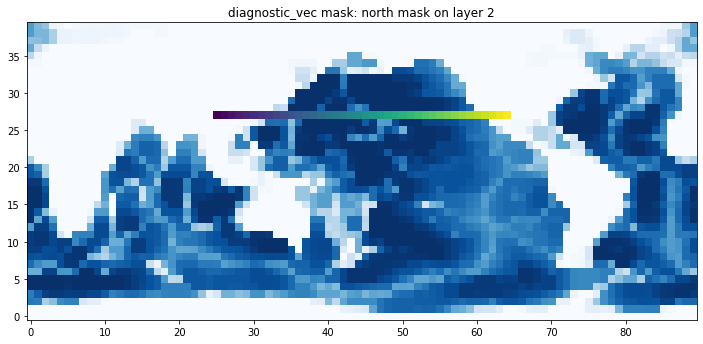

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

example_dir = os.getcwd()
mask_name = 'north' # choose north, south, east, or west
layer = 2

plt.figure(figsize=(12,6))

bathy_path = os.path.join(example_dir,'global','input','bathymetry.bin')
bathy_grid = np.fromfile(bathy_path,'>f4').reshape((40,90))
plt.imshow(bathy_grid,origin='lower',cmap='Blues_r')

if layer==0:
    mask_path = os.path.join(example_dir,'global','input','dv', mask_name+'_mask.bin')
else:
    mask_path = os.path.join(example_dir,'global','input','dv', mask_name+'_mask_i'+str(layer)+'.bin')

mask_grid = np.fromfile(mask_path,'>f4').reshape((40,90))
mask_grid = np.ma.masked_where(mask_grid==0, mask_grid)
plt.imshow(mask_grid, origin='lower')

plt.title('diagnostic_vec mask: '+mask_name+' mask on layer '+str(layer))
plt.show()

## 2.2 Build the global model

Next, build the model according to the specifications of your machine, e.g.

## 2.3 Run the global model
Finally, run the model:

# Section 3: The Regional Model

## 3.1 Setup the regional model
Next, the output from the global model will be used to prescribe the external forcing and boundary conditions for the regional model. First, we will create the regional model fields in the following steps:
1. Subset bathymetry and hydography fields from the global to regional domain; create exf conditions
2. Create boundary conditions from the global model output to be applied with the prescribe_vec package
3. Copy unchanged files from the core tutorial

There are three convenient scripts in the regional/input directory which carry out the steps above:

### 3.1.1 The prescribe_vec masks
The prescribe vec masks are constructed by sequentially enumerating points in the domain in the order in which they are aligned in the presciption fields. In this example, boundary layers are prescribed in a series of 4 masks which are enumerated from the exterior of the domain to the interior:

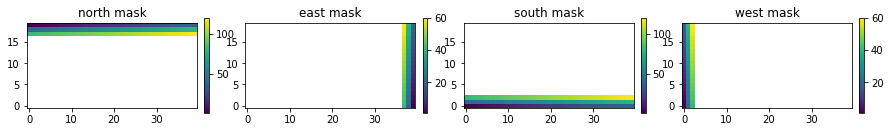

In [2]:
rows = 20
cols = 40

plt.figure(figsize=(15,4))

masks = ['north','east','south','west']
for m in range(len(masks)):
    mask_grid = np.fromfile(os.path.join(example_dir,'regional','input','bcs','BC_'+masks[m]+'.bin'),'>f4')
    mask_grid = np.reshape(mask_grid,(rows,cols))
    mask_grid = np.ma.masked_where(mask_grid==0, mask_grid)
    plt.subplot(1,4,m+1)
    C = plt.imshow(mask_grid,origin='lower')
    plt.colorbar(C,fraction=0.026, pad=0.04)
    plt.title(masks[m]+' mask')


plt.show()

## 3.1.2 The prescribe_vec fields
The masks above can be compared to the respective files that are prescribed on these masks:

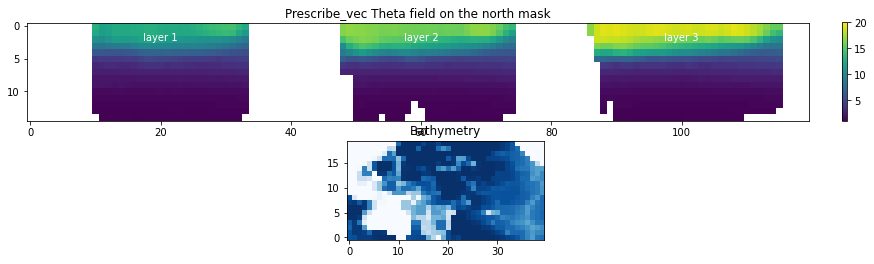

In [3]:
mask_name = 'north' # choose north, south, east, or west
var_name = 'Theta' # choose Theta, Salt, Uvel, Vvel, or Etan
Nr = 15
n_timesteps = 2160
plot_timestep = 1117
layers = 3
if mask_name in ['north','south']:
    N = 40
if mask_name in ['west','east']:
    N = 20
var_name_to_bounds = {'Uvel':[-0.2,0.2],'Vvel':[-0.2,0.2],'Theta':[1,20],'Salt':[32.5,36]}
var_name_to_cmap = {'Uvel':'seismic','Vvel':'seismic','Theta':'viridis','Salt':'viridis'}

file_path = os.path.join(example_dir,'regional','input','bcs','BC_'+mask_name+'_'+var_name.upper()+'.bin')
pv_grid = np.fromfile(file_path,'>f4').reshape((n_timesteps,Nr,layers*N))

fig = plt.figure(figsize=(15,4))

plt.subplot(2,1,1)
plot_grid = pv_grid[plot_timestep,:,:]
plot_grid = np.ma.masked_where(plot_grid==0, plot_grid)
C = plt.imshow(plot_grid,cmap=var_name_to_cmap[var_name],
               vmin=var_name_to_bounds[var_name][0],vmax=var_name_to_bounds[var_name][1])
plt.colorbar(C,fraction=0.026, pad=0.04)
plt.text(N/2,1,'layer 1',ha='center',va='top',color='w')
plt.text(N+N/2,1,'layer 2',ha='center',va='top',color='w')
plt.text(2*N+N/2,1,'layer 3',ha='center',va='top',color='w')
plt.title('Prescribe_vec '+var_name+' field on the '+mask_name+' mask')

plt.subplot(2,3,5)
bathy_path = os.path.join(example_dir,'regional','input','bathymetry.bin')
bathy_grid = np.fromfile(bathy_path,'>f4').reshape((20,40))
plt.imshow(bathy_grid,origin='lower',cmap='Blues_r')
plt.title('Bathymetry')
plt.show()

## 3.2 Build the regional model

Next, build the model as was done for the global model

## 3.3 Run the regional model
Now, the model is ready to run:

# Section 4: Solution Comparison
In this section, we compare solutions between the global model and the regional model. First, we make functions to read in the solutions and plot them. Then, we use an interactive slide to observe the solution through time.

## 4.1 Create comparison functions

### 4.1.1 Function to read solution

In [4]:
def read_solution_from_domain(example_dir,domain_name,var_name,n_timesteps):
    grid_level = ['UVEL','VVEL','THETA','SALT'].index(var_name.upper())
    if domain_name == 'global':
        rows = 40
        cols = 90
    if domain_name == 'regional':
        rows = 20
        cols = 40
    solution_grid = np.zeros((n_timesteps,rows,cols))
    for timestep in range(n_timesteps):
        file_name = os.path.join(example_dir,domain_name,'run','diags','diagsDyn',
                                'diagsDyn.'+'{:010d}'.format(timestep+1)+'.data')
        grid = np.fromfile(file_name,'>f4')
        grid = grid.reshape((4,rows,cols))
        grid = grid[grid_level,:,:]
        solution_grid[timestep,:,:] = grid
    if domain_name=='global':
        min_row = 10
        max_row = 29
        min_col= 25
        max_col = 64
        solution_grid = solution_grid[:,min_row:max_row+1,min_col:max_col+1]
    return(solution_grid)
    

### 4.1.2 Function to plot solution comparison

In [45]:
from matplotlib.gridspec import GridSpec

def plot_solution_panel(time,global_soln,regional_soln,var_name):
    
    var_name_to_bounds = {'Uvel':[-0.2,0.2]}
    plt.figure(figsize=(15,6))
    plt.subplot(2,3,1)
    C = plt.imshow(global_soln[time,:,:],origin='lower',
               vmin=var_name_to_bounds[var_name][0],vmax=var_name_to_bounds[var_name][1])
    plt.colorbar(C,fraction=0.026, pad=0.04)
    plt.title('Global Solution\n(subset to regional)')
    
    plt.subplot(2,3,2)
    C = plt.imshow(regional_soln[time,:,:],origin='lower',
               vmin=var_name_to_bounds[var_name][0],vmax=var_name_to_bounds[var_name][1])
    plt.colorbar(C,fraction=0.026, pad=0.04)
    plt.title('Regional Solution')
    
    plt.subplot(2,3,3)
    difference_matrix = global_soln-regional_soln
    C = plt.imshow(difference_matrix[time,:,:],origin='lower',cmap='seismic',
               vmin=var_name_to_bounds[var_name][0],vmax=var_name_to_bounds[var_name][1])
    plt.colorbar(C,fraction=0.026, pad=0.04)
    plt.title('Global - Regional\nDifference')
    
    plt.subplot(2,3,4)
    test_row = 10
    test_col = 22
    global_timeseries = global_soln[:,test_row,test_col]
    regional_timeseries = regional_soln[:,test_row,test_col]
    plt.plot(global_timeseries,label='global')
    plt.plot(regional_timeseries,label='regional')
    min_val = np.min([np.min(global_timeseries),np.min(regional_timeseries)])
    max_val = np.max([np.max(global_timeseries),np.max(regional_timeseries)])
    plt.plot([time,time],[min_val,max_val],'k--')
    plt.legend()
    plt.title('Timeseries at row = '+str(test_row)+', col = '+str(test_col))
    
    
    plt.subplot(2,3,6)
    C = plt.imshow(difference_matrix[time,:,:]==0,origin='lower',cmap='Greys_r',vmin=0,vmax=1)
    plt.colorbar(C,fraction=0.026, pad=0.04)
    plt.title('Difference Mask (1 = no difference)')
    plt.show()

## 4.2 Compare Global vs Regional Solutions

In [46]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

n_timesteps = 19
var_name = 'Uvel'
global_solution = read_solution_from_domain(example_dir,'global',var_name,n_timesteps)
regional_solution = read_solution_from_domain(example_dir,'regional',var_name,n_timesteps)
timesteps = np.arange(n_timesteps)
interact(plot_solution_panel,
         time=widgets.IntSlider(min=0, max=n_timesteps-1, step=1, value=0),
         global_soln = fixed(global_solution),
         regional_soln = fixed(regional_solution),
         var_name = fixed(var_name))


interactive(children=(IntSlider(value=0, description='time', max=18), Output()), _dom_classes=('widget-interac…

<function __main__.plot_solution_panel(time, global_soln, regional_soln, var_name)>